In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

In [3]:
import scgpt as scg
import sys
from pathlib import Path

/opt/conda/rpeyser/envs/scgpt_3/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/opt/conda/rpeyser/envs/scgpt_3/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/opt/conda/rpeyser/envs/scgpt_3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.cuda.is_available()

True

# read data

In [5]:
h5ad_loc="/data/rna_rep_learning/onek1k/eab6ad1d-665b-4ea7-9bbb-59f30e610322.h5ad"

In [6]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

In [7]:
adata

AnnData object with n_obs × n_vars = 1248980 × 36571
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_umap', 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


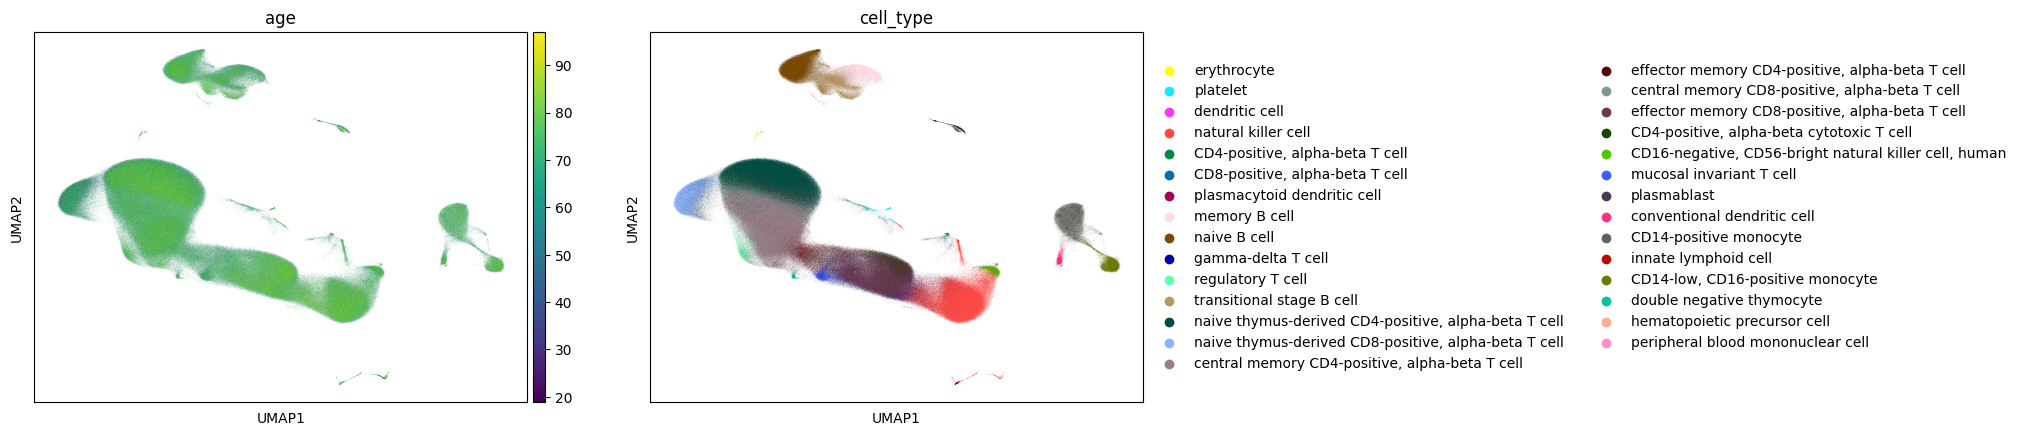

In [18]:
sc.pl.umap(adata, color=['age', 'cell_type'])

### explore & pre-process target variable

In [25]:
len(adata.obs.donor_id.unique())

981

In [26]:
adata.obs['age'] = [int(s.split("-")[0]) for s in adata.obs.development_stage]

(array([ 35.,  41.,  55.,  60.,  71., 177., 249., 184.,  95.,  14.]),
 array([19. , 26.8, 34.6, 42.4, 50.2, 58. , 65.8, 73.6, 81.4, 89.2, 97. ]),
 <BarContainer object of 10 artists>)

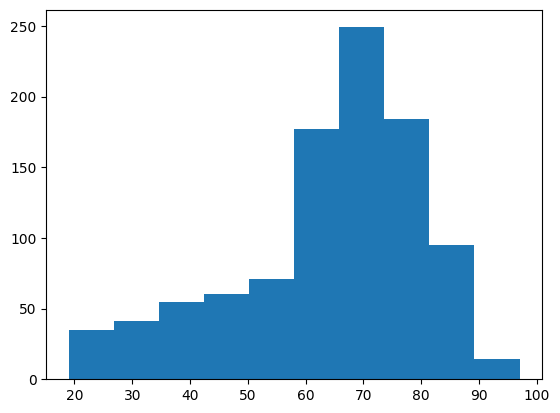

In [8]:
plt.hist(adata.obs[['donor_id','age']].drop_duplicates().age)

In [28]:
#avg distance from mean
x = adata.obs[['donor_id','age']].drop_duplicates().age
np.mean(np.abs(x-x.mean()))

12.938529304491766

# prepare scGPT embeddings

In [ ]:
# open notebook on zeus for this, since scGPT is installed there. use kernel "scgpt2"
# follow this tutorial https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb

In [ ]:
import scgpt as scg
import sys
from pathlib import Path

In [ ]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [13]:
# scGPT code assumes counts are stored in X, make sure this is the case
print(adata.X.min())
print(adata.X.max())

0.0
16282.0


In [142]:
adata

AnnData object with n_obs × n_vars = 1248980 × 36571
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'id_in_vocab'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title', 'neighbors', 'umap', 'cell_type_colors', 'donor_id_colors', 'assay_colors'
    obsm: 'X_azimuth_spca', 

In [ ]:
adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col="feature_name",
    obs_to_save=adata.obs.columns,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

In [34]:
#save this new adata
adata.write("/data/rna_rep_learning/onek1k/onek1k_w_scGPT_embeds.h5ad")

In [6]:
adata = sc.read_h5ad("/data/rna_rep_learning/onek1k/onek1k_w_scGPT_embeds.h5ad")

In [15]:
adata

AnnData object with n_obs × n_vars = 1248980 × 36571
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'id_in_vocab'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_umap', 'X_harmony', 'X_pca', 'X_umap', 'X_scGPT'
    varm: 'PCs'

In [14]:
adata.obsm['X_scGPT'].shape

(1248980, 512)

### Check that these scGPT embeddings look reasonable

In [15]:
sc.pp.neighbors(adata, use_rep="X_scGPT")

In [17]:
sc.tl.umap(adata)

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


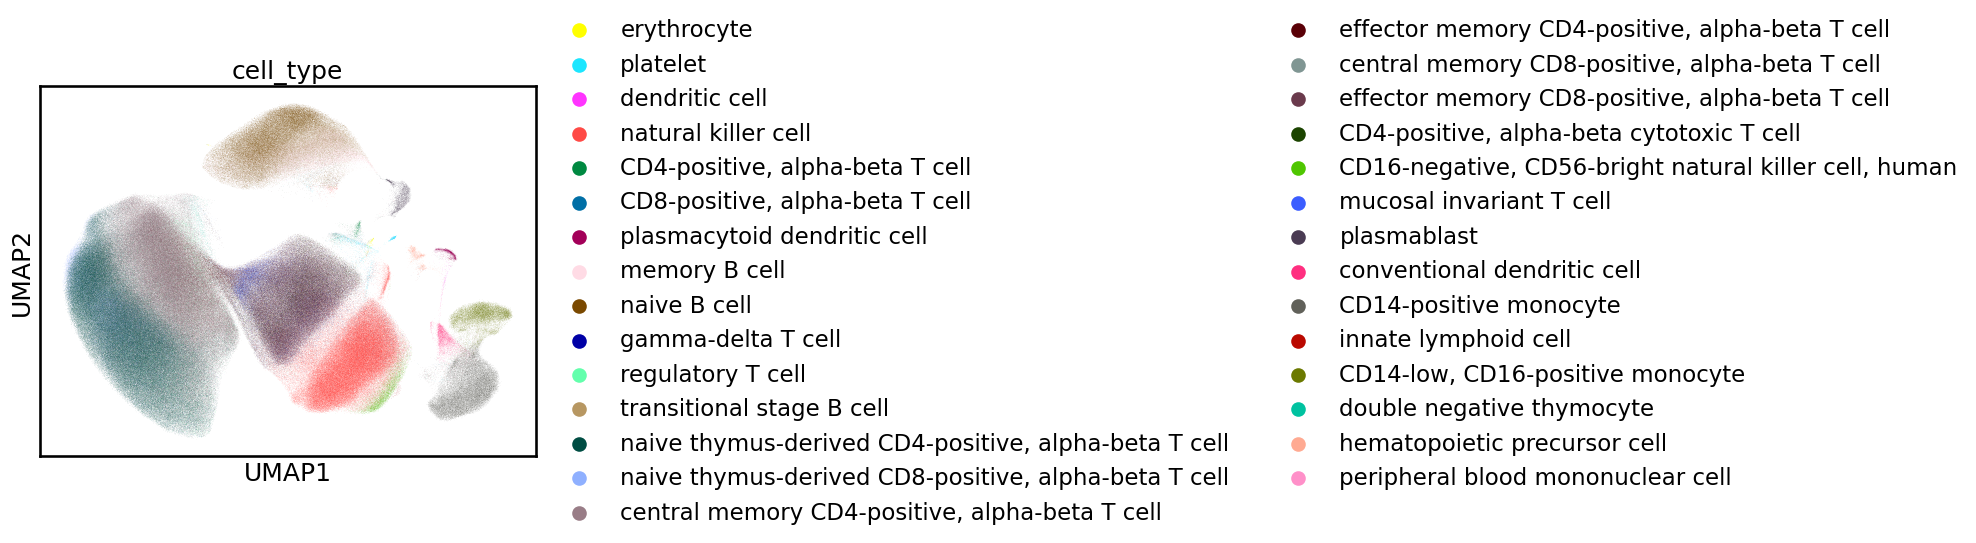

In [18]:
sc.pl.umap(adata, color="cell_type")

# define NN to predict age

In [123]:
class SimpleNN_age(pl.LightningModule):
    def __init__(self, input_size, hidden1_size=30, hidden2_size=15, output_size=1, lr=0.01):#, data_name=None, model_name=None):
        super(SimpleNN_age, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.lr = lr
        #self.logger = pl.loggers.TensorBoardLogger("logs/", name=data_name, version=model_name) #does it need to be self.logger?

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = nn.MSELoss()(outputs, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        #accuracy = (predicted == y).sum().item() / y.size(0)
        MAE = nn.L1Loss()(outputs, y)
        self.log('train_MAE', MAE, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        val_loss = nn.MSELoss()(outputs, y)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log validation loss
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        MAE = nn.L1Loss()(outputs, y)
        self.log('val_MAE', MAE, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return val_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# input mean PCs

In [87]:
### create dataloader

input_size = 50
sample_id = 'donor_id'
pseudobulk_input = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs[sample_id]).reset_index().groupby(sample_id).mean()

#define targets
targets = adata.obs[[sample_id, 'age']].drop_duplicates().age
targets = torch.tensor(targets, dtype=torch.float)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## baseline: avg distance from mean

In [52]:
# val mean absolute error if always predict train set mean
torch.mean(torch.abs(targets[val_data.indices] - targets[train_data.indices].mean()))

tensor(12.7362)

In [53]:
# test mean absolute error if always predict train set mean
torch.mean(torch.abs(targets[test_data.indices] - targets[train_data.indices].mean()))

tensor(12.6651)

## NN

In [38]:
### train model

# Example input and target tensors (replace these with your own data)
hidden_size = 30

# Initialize the Lightning model
lr = 0.0001
logger = pl.loggers.TensorBoardLogger('logs/', name="onek1k_age_3layers_50pcs_mean_lr{}".format(lr), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN_age(input_size, output_size=1, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=1000, gpus=1, logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | fc1   | Linear | 1.5 K 
1 | relu1 | ReLU   | 0     
2 | fc2   | Linear | 465   
3 | relu2 | ReLU   | 0     
4 | fc3   | Linear | 16    
---------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [39]:
print(trainer.callback_metrics)

{'train_loss': tensor(287.7019), 'train_loss_step': tensor(293.6136), 'train_MAE': tensor(13.3217), 'train_MAE_step': tensor(13.3525), 'val_loss': tensor(280.3183), 'val_loss_epoch': tensor(280.3183), 'val_MAE': tensor(13.3772), 'val_MAE_epoch': tensor(13.3772), 'train_loss_epoch': tensor(287.7019), 'train_MAE_epoch': tensor(13.3217)}


## KNN

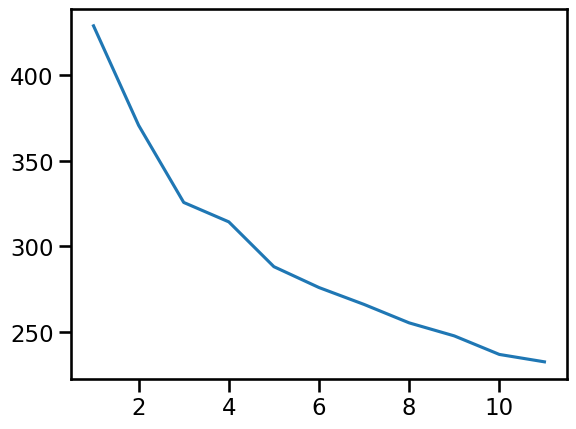

In [88]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)
    #print("val acc ", val_acc)
    #print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    #print("\n")



In [89]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best K =  11
val MAE:  12.2517
val MSE:  232.35303
test MAE:  12.280098
test MSE:  260.4139


### linear regression 

In [90]:
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])

preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
print("val MAE: ", mean_absolute_error(targets[val_data.indices], preds))
print("val MSE: ", mean_squared_error(targets[val_data.indices], preds))

preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

val MAE:  13.070448446964786
val MSE:  273.48511727165857
test MAE:  12.502770126372488
test MSE:  251.92740449124486


### l1 logistic regression

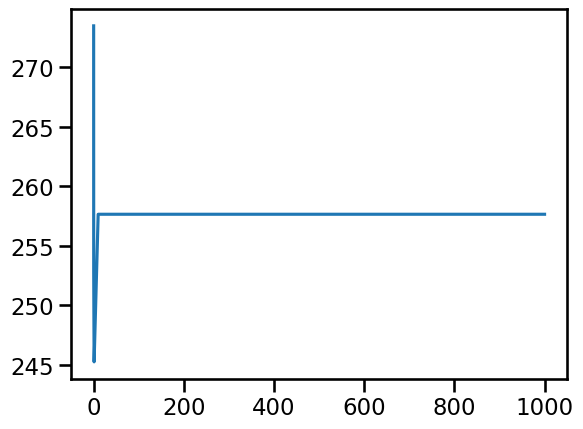

In [94]:
val_maes = []
val_mses = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1,10,100,1000]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [95]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best alpha =  1
val MAE:  12.464887952003778
val MSE:  245.2319261566147
test MAE:  12.254958629369277
test MSE:  246.19770178456344


### random forest

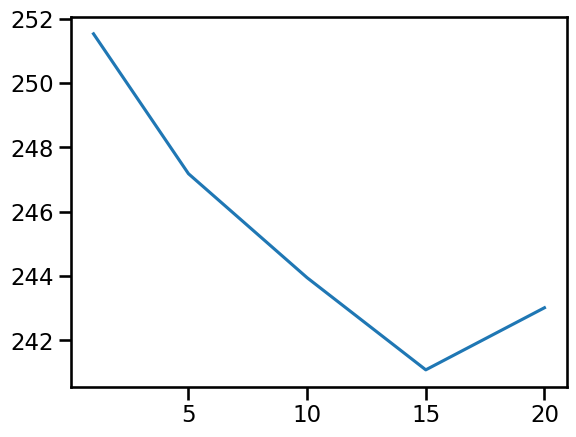

In [96]:
val_maes = []
val_mses = []
Cs = [1,5,10,15,20]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c, random_state=18)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [97]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc, random_state=18)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best min_samples_leaf =  15
val MAE:  12.220099633486713
val MSE:  241.0779990836374
test MAE:  12.292850685644789
test MSE:  247.67433477378606


# train on scGPT cell reps

In [98]:
### create dataloader

input_size = 512
sample_id = 'donor_id'
emb_name = 'X_scGPT'

pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs[sample_id]).reset_index().groupby(sample_id).mean()

#define targets
targets = adata.obs[[sample_id, 'age']].drop_duplicates().age
targets = torch.tensor(targets, dtype=torch.float)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
### train model

# Initialize the Lightning model
lr = 0.001
logger = pl.loggers.TensorBoardLogger('logs/', name="onek1k_age_3layers_scGPTembeds_mean_lr{}".format(lr), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN_age(input_size, hidden1_size=256, hidden2_size=128, output_size=1, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=1000,logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

In [9]:
print(trainer.callback_metrics)

{'train_loss': tensor(280.7616, device='cuda:0'), 'train_loss_step': tensor(280.7616, device='cuda:0'), 'train_MAE': tensor(12.4451, device='cuda:0'), 'train_MAE_step': tensor(12.4451, device='cuda:0'), 'val_loss': tensor(257.7692, device='cuda:0'), 'val_loss_epoch': tensor(257.7692, device='cuda:0'), 'val_MAE': tensor(12.8293, device='cuda:0'), 'val_MAE_epoch': tensor(12.8293, device='cuda:0'), 'train_loss_epoch': tensor(283.2568, device='cuda:0'), 'train_MAE_epoch': tensor(13.3243, device='cuda:0')}


## KNN

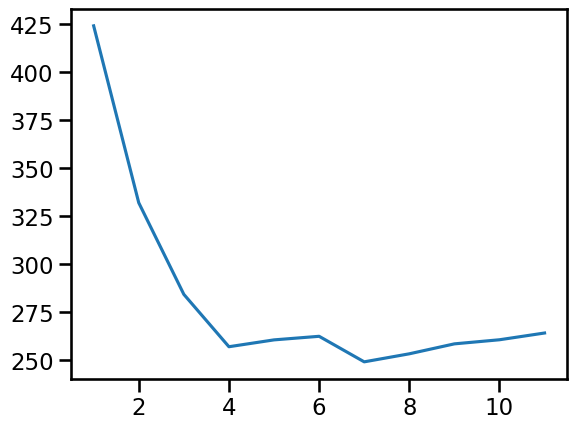

In [99]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)
    #print("val acc ", val_acc)
    #print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    #print("\n")



In [100]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best K =  7
val MAE:  12.460642
val MSE:  249.18282
test MAE:  13.144788
test MSE:  283.12244


### linear regression 

In [101]:
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])

preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
print("val MAE: ", mean_absolute_error(targets[val_data.indices], preds))
print("val MSE: ", mean_squared_error(targets[val_data.indices], preds))

preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

val MAE:  23.997236
val MSE:  1109.3264
test MAE:  24.93201
test MSE:  993.69446


### l1 logistic regression

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.004e+04, tolerance: 1.914e+01
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e+04, tolerance: 1.914e+01
  model = cd_fast.enet_coordinate_descent(


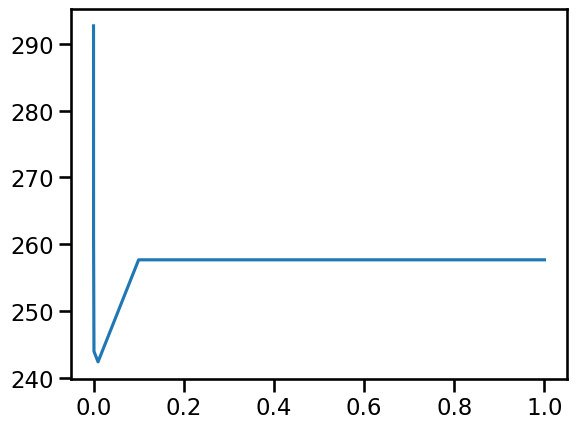

In [79]:
val_maes = []
val_mses = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [80]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best alpha =  0.01
val MAE:  12.392689
val MSE:  242.35504
test MAE:  12.30429
test MSE:  247.51678


### random forest

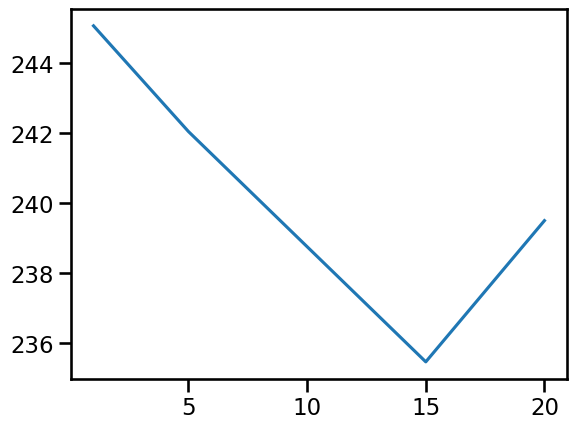

In [82]:
val_maes = []
val_mses = []
Cs = [1,5,15,20]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c, random_state=18)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [83]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc, random_state=18)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best min_samples_leaf =  15
val MAE:  12.166146602945966
val MSE:  235.44822244299556
test MAE:  12.142087043411918
test MSE:  244.8352060225619


# train on cell type proportions

In [ ]:
# remove doublets, which can be uniquely identified either by adata.obs.cell_type!="peripheral blood mononuclear cell" or adata.obs.predicted.celltype.l2=="doublet"

In [130]:
input_size = len(adata.obs.cell_type.cat.categories)

## Input
celltype_counts_df = pd.DataFrame(adata.obs[adata.obs.cell_type!="peripheral blood mononuclear cell"].groupby('donor_id').cell_type.value_counts()).rename({'cell_type':'cell_type_counts'},axis=1).reset_index().pivot(index="donor_id", columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df

#define targets
targets = adata.obs[[sample_id, 'age']].drop_duplicates().age
targets = torch.tensor(targets, dtype=torch.float)

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(celltype_fracs_df)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


In [125]:
### train model

# Initialize the Lightning model
lr = 0.001
logger = pl.loggers.TensorBoardLogger('logs/', name="onek1k_age_3layers_scGPTembeds_mean_lr{}".format(lr), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN_age(input_size, hidden1_size=256, hidden2_size=128, output_size=1, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=100,logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name  | Type   | Params
---------------------------------
0 | fc1   | Linear | 7.7 K 
1 | relu1 | ReLU   | 0     
2 | fc2   | Linear | 32.9 K
3 | relu2 | ReLU   | 0     
4 | fc3   | Linear | 129   
---------------------------------
40.7 K    Trainable params
0         Non-trainable params
40.7 K    Total params
0.163     Total estimated model params size (MB)


Epoch 0: 100%|█████████████| 22/22 [00:00<00:00, 95.94it/s, v_num=0852, train_loss_step=3.64e+3, train_MAE_step=58.60]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.25it/s]
Epoch 1: 100%|█| 22/22 [00:00<00:00, 92.84it/s, v_num=0852, train_loss_step=3.16e+3, train_MAE_step=52.40, val_loss_st
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.47it/s]
Epoch 2: 100%|█| 22/22 [00:00<00:00, 73.26it/s, v_num=0852, train_loss_step=2.93e+3, train_MAE_step=52.20, val_loss_st
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.93it/s]
Epoch 3: 100%|█| 22/22 [00:00<00:00, 95.06it/s, v_num=0852, train_loss_step=1.15e+3, train_MAE_step=28.80, val_loss_st
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|█████████████

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█| 22/22 [00:00<00:00, 32.89it/s, v_num=0852, train_loss_step=382.0, train_MAE_step=15.30, val_loss_ste


In [126]:
print(trainer.callback_metrics)

{'train_loss': tensor(280.1064), 'train_loss_step': tensor(381.8074), 'train_MAE': tensor(12.9419), 'train_MAE_step': tensor(15.2857), 'val_loss': tensor(257.6150), 'val_loss_epoch': tensor(257.6150), 'val_MAE': tensor(12.8478), 'val_MAE_epoch': tensor(12.8478), 'train_loss_epoch': tensor(280.1064), 'train_MAE_epoch': tensor(12.9419)}


## KNN

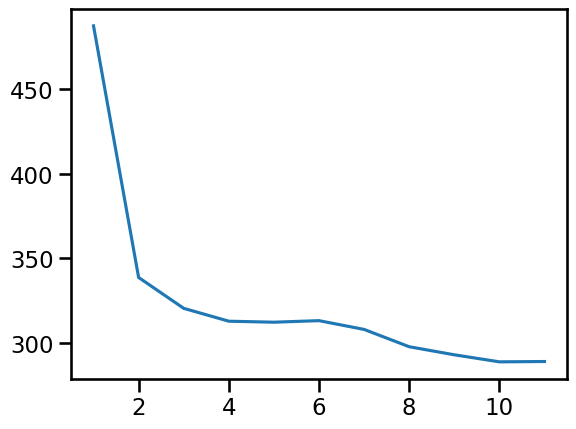

In [131]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)
    #print("val acc ", val_acc)
    #print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    #print("\n")



In [132]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best K =  10
val MAE:  13.27551
val MSE:  289.08536
test MAE:  13.192568
test MSE:  281.89307


### linear regression 

In [133]:
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])

preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
print("val MAE: ", mean_absolute_error(targets[val_data.indices], preds))
print("val MSE: ", mean_squared_error(targets[val_data.indices], preds))

preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

val MAE:  13.150297619047619
val MSE:  269.0042350924745
test MAE:  12.977618243243244
test MSE:  264.5287261138091


### l1 logistic regression

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+04, tolerance: 1.914e+01
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+03, tolerance: 1.914e+01
  model = cd_fast.enet_coordinate_descent(


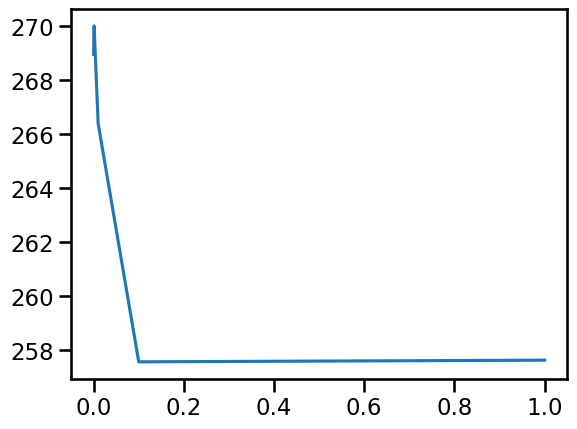

In [134]:
val_maes = []
val_mses = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:], targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [135]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best alpha =  0.1
val MAE:  12.734282400950352
val MSE:  257.5770612790722
test MAE:  12.632792544351215
test MSE:  254.73403017599077


### random forest

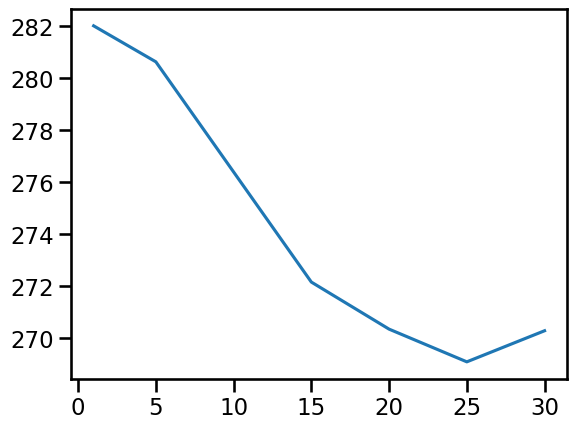

In [140]:
val_maes = []
val_mses = []
Cs = [1,5,15,20,25,30]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c, random_state=18)
    neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
    preds = neigh.predict(pseudobulk_input.iloc[val_data.indices,:])
    val_mae = mean_absolute_error(targets[val_data.indices], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(targets[val_data.indices], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [141]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc, random_state=18)
neigh.fit(pseudobulk_input.iloc[train_data.indices,:],targets[train_data.indices])
preds = neigh.predict(pseudobulk_input.iloc[test_data.indices,:])
print("test MAE: ", mean_absolute_error(targets[test_data.indices], preds))
print("test MSE: ", mean_squared_error(targets[test_data.indices], preds))

best min_samples_leaf =  25
val MAE:  12.947932305240556
val MSE:  269.0784791087881
test MAE:  12.657275265094372
test MSE:  256.27934744543626
